In [306]:
#Copyright (c) 2022 Giovanni Squillero
#https://github.com/squillero/computational-intelligence
#Free for personal or classroom use; see LICENSE.md for details.


import random
import sys
from matplotlib import pyplot as plt

In [307]:
PROBLEM_SIZE = 10

POPULATION_SIZE = 5
OFFSPRING_SIZE = 6
NUM_GENERATIONS = 100
CHAMPION = ()
actual_best_fitness = 0.8
MIN_NUMBER = sys.float_info.min

In [308]:
def problem(N, seed=42):
    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

In [309]:
GOAL={i for i in range(PROBLEM_SIZE)}
list_of_lists=problem(PROBLEM_SIZE)
print("lista iniziale generata con seed = 42: \n", list_of_lists)

lista iniziale generata con seed = 42: 
 [[0], [1], [0], [4], [0], [1], [4], [4], [4], [1, 3], [0, 1], [2], [1], [0], [0, 2], [2, 4], [3], [3], [4], [2, 4], [0], [1], [0, 1], [3], [2, 3]]


In [310]:
def concat_list_of_lists(state):
    c_list = []
    for n in state:
        c_list += list_of_lists[n]
    return c_list

def compute_fitness(state):
    genome = []
    for i in range(len(list_of_lists)):
        if state[i]==True:
            genome.append(i) #un genome è costituito dagli indici delle liste all'interno della list_of_lists    
    c_list=concat_list_of_lists(genome)
    repetitions=len(c_list)-len(set(c_list))
    if repetitions==0:
        repetitions=MIN_NUMBER
    normalized_cost=repetitions/len(c_list)    
    return normalized_cost
    
def goal_test(state):
    genome = []
    for i in range(len(list_of_lists)):
        if state[i]==True:
            genome.append(i) #un genome è costituito dagli indici delle liste all'interno della list_of_lists
    #print(genome)        
    if set(concat_list_of_lists(genome)) == GOAL:
        return True
    return False

PARENT SELECTION, MUTATION AND CROSS_OVER IMPLEMENTATIONS

In [311]:
#PARENT SELECTION
#prendo k individual scelti random dalla popolazione e restituisco quello con la min fitness 
def tournament(population, tournament_size=POPULATION_SIZE//2):
    #random choices prende un elemento random da una lista
    #k => ritorna k individual dalla lista
    return min(random.choices(population, k=tournament_size), key=lambda i: i[1])

#CROSS_OVER IMPLEMENTATION
def cross_over(g1, g2): #prendo due genomi e restituisco un individuo con caratteristiche 50% di g1 e 50% di g2
    print("parenti scelti", g1, g2)
    cut = random.randint(0, len(list_of_lists) - 1)
    print("taglio sull'indice", cut)
    print("padre1", g1[:cut])
    print("padre2", g2[cut:])
    print("genoma dopo cross over")
    print(g1[:cut] + g2[cut:])
    return g1[:cut] + g2[cut:]

#MUTATION IMPLEMENTATION
def mutation(g): #prende un elemento random all'interno del genome e lo swicha
    print("genoma prima della mutation", g)
    point = random.randint(0, len(list_of_lists) - 1)
    print("indice mutato:", point)
    g1=g[:point] + [1-g[point]] + g[point + 1 :]
    print("genoma dopo della mutation\n", g1)
    return g1


INIZIAL POPULATION

In [312]:
#CREO LA POPOLAZIONE INIZIALE DI DIMENSIONE POPULATION_SIZE

population = [] 
#popolation = lista di individual
#individual = (genoma,fitness)

for _ in range(POPULATION_SIZE):
    genome = []
    for _ in range(len(list_of_lists)):
        genome.append(random.choice([1, 0]))

    fitness = compute_fitness(genome)
    population.append((genome,fitness))
print("popolazione iniziale\n", population)

popolazione iniziale
 [([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0], 0.6666666666666666), ([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1], 0.7058823529411765), ([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1], 0.6875), ([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1], 0.7368421052631579), ([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0], 0.75)]


Evolution

In [313]:
#GENERO I NUOVI OFFSPRING
fitness_log = [(0, i[1]) for i in population]

for g in range(NUM_GENERATIONS): #per ogni generazione
    print("iterazione:", g)
    
    offspring = list()
    for i in range(OFFSPRING_SIZE): #genero i nuovi offspring
        print("genero offspring numero:", i)
        if random.random() < 0.3:
            p = tournament(population)
            o = mutation(p[0])
        else:
            p1 = tournament(population)
            p2 = tournament(population)
            o = cross_over(p1[0], p2[0])
        fitness = compute_fitness(o)
        print("fitness= ", fitness)
        fitness_log.append((g + 1, fitness))
        offspring.append((o, fitness))
    population += offspring #aggiungo tutti gli offspring alla popolazione
    print("popolazione con i nuovi offsping\n", population)
    population = sorted(population, key=lambda i: i[1], reverse=False)[:POPULATION_SIZE] #prendo i POPULAZION_SIZE migliori
    print("popolazione dopo aver preso solo i migliori individual\n", population)
    person= population[0:1]

    if (actual_best_fitness > person[0][1]) and (goal_test(person[0][0])):
        actual_best_fitness = person[0][1]
        CHAMPION = person.copy()

iterazione: 0
genero offspring numero: 0
parenti scelti [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0] [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
taglio sull'indice 1
padre1 [1]
padre2 [1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
genoma dopo cross over
[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]
fitness=  0.7368421052631579
genero offspring numero: 1
parenti scelti [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1] [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]
taglio sull'indice 14
padre1 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1]
padre2 [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]
genoma dopo cross over
[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]
fitness=  0.6666666666666666
genero offspring numero: 2
genoma prima della mutation [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1

In [314]:
best_sol = []
print("migliore soluzione trovata: ", CHAMPION)
for i in range(len(list_of_lists)):
    if CHAMPION[0][0][i] == True:
        best_sol.append(list_of_lists[i])
print("soluzione migliore:", best_sol)

migliore soluzione trovata:  [([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0], 4.4501477170144e-309)]
soluzione migliore: [[2, 4], [3], [0], [1]]


Performance Evaluation

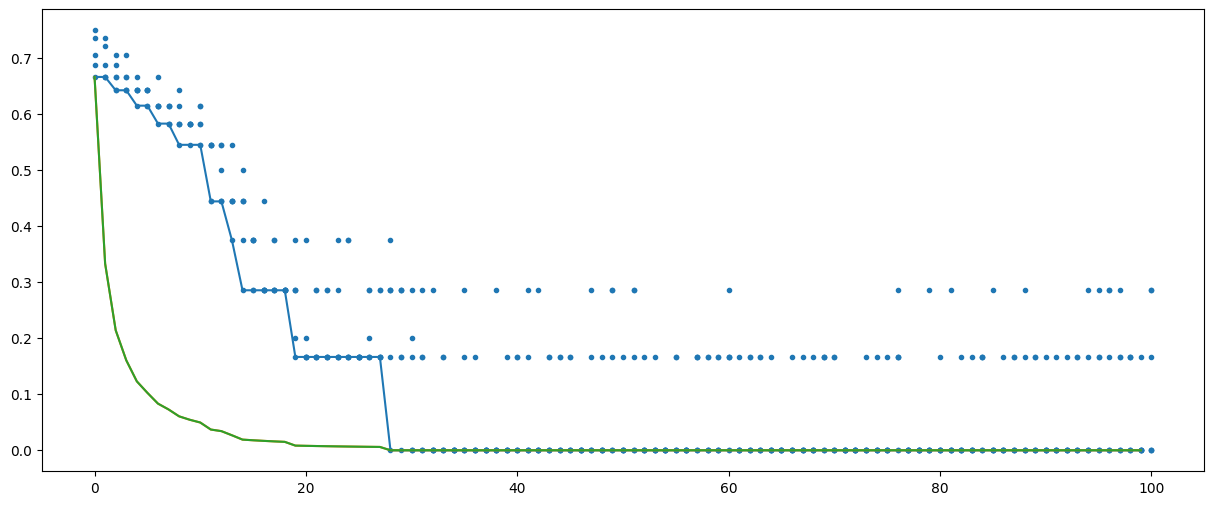

In [315]:
off_line = [min(f[1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(NUM_GENERATIONS)]
on_line = [min(f[1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(NUM_GENERATIONS)]
gen_best = [min(f[1] for f in fitness_log if f[0] == x) for x in range(NUM_GENERATIONS)]

plt.figure(figsize=(15, 6))
plt.scatter([x for x, _ in fitness_log], [y for _, y in fitness_log], marker=".")
plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)])
plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)])
plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)])